Missing values in each column:
DateTime         0
Unnamed: 1     960
Temperature      1
Humidity         1
pH               1
dtype: int64
Columns in DataFrame: ['DateTime', 'Unnamed: 1', 'Temperature', 'Humidity', 'pH']
The index is successfully set as a DatetimeIndex.
Correlation Matrix:
             Temperature  Humidity        pH
Temperature     1.000000 -0.912578  0.278962
Humidity       -0.912578  1.000000 -0.333547
pH              0.278962 -0.333547  1.000000


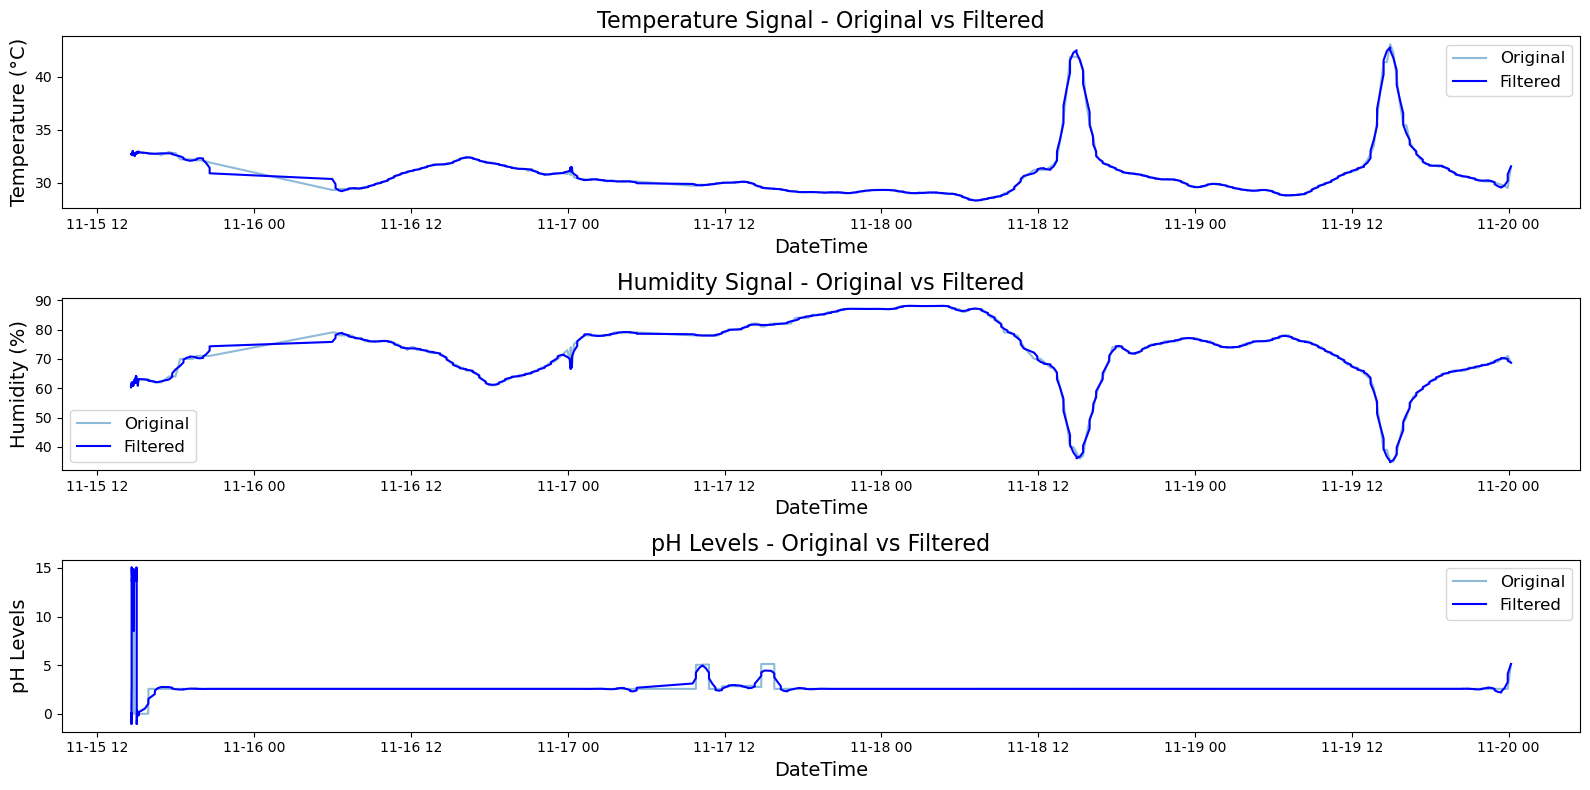

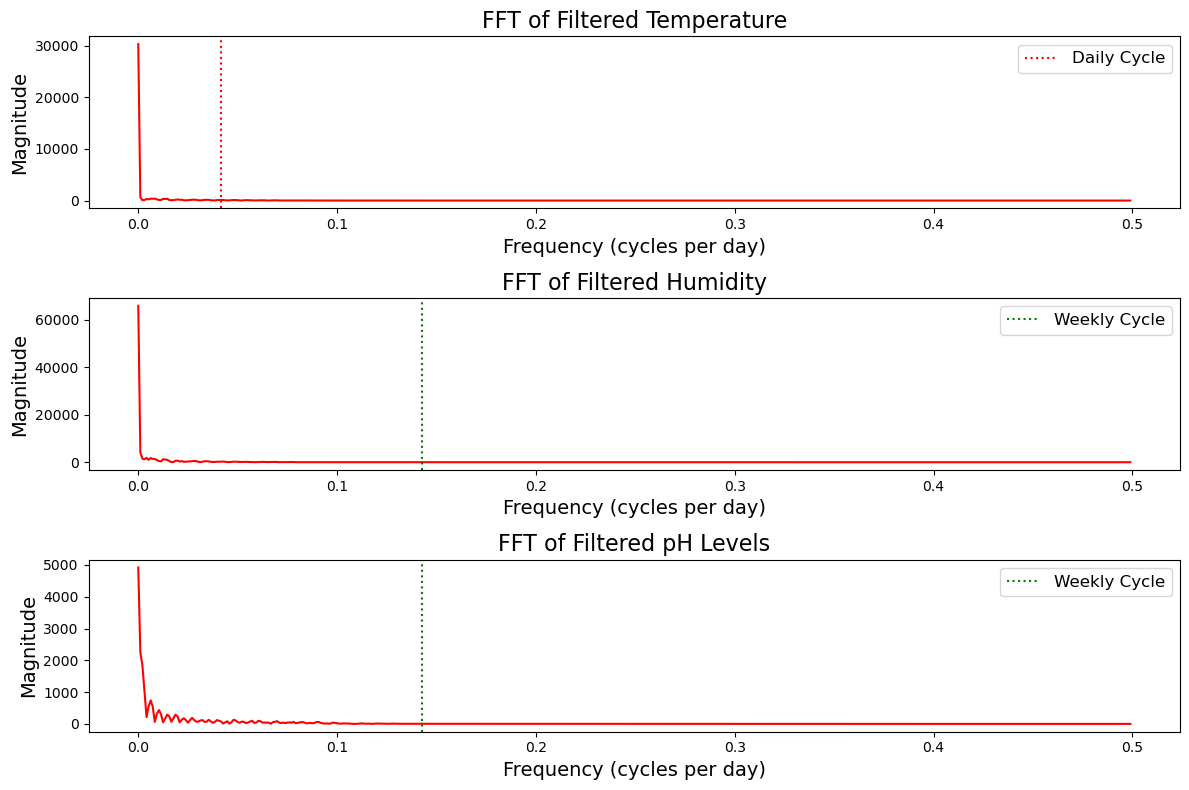

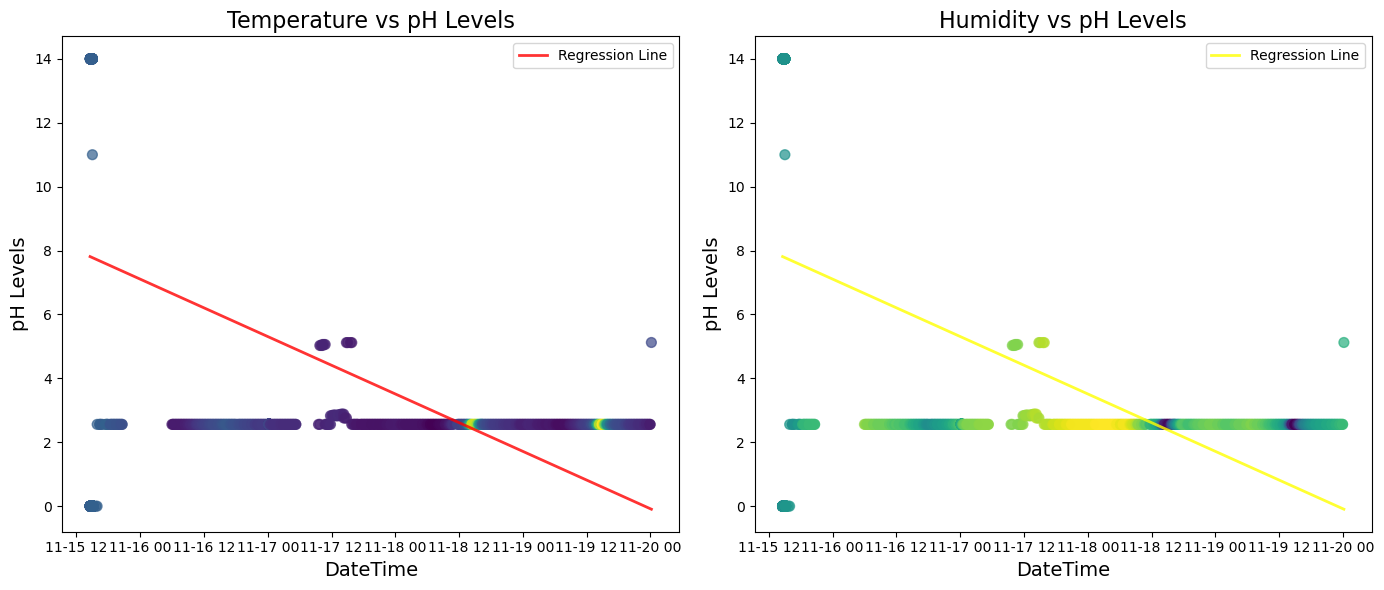

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import fft
from sklearn.linear_model import LinearRegression

data = pd.read_excel(r'ESP32_DataSet.xlsx', sheet_name="Sheet1")

print("Missing values in each column:")
print(data.isnull().sum())
print("Columns in DataFrame:", data.columns.tolist())

data.columns = data.columns.str.strip()

for col in ['Temperature', 'Humidity', 'pH']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    else:
        print(f"Column '{col}' does not exist.")

data[['Temperature', 'Humidity', 'pH']] = data[['Temperature', 'Humidity', 'pH']].fillna(data[['Temperature', 'Humidity', 'pH']].mean())

if 'DateTime' in data.columns:
    data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')  # Ensure conversion with error handling

    if data['DateTime'].isnull().any():
        print("Warning: Some DateTimes could not be converted.")
              
    data.set_index('DateTime', inplace=True)
else:
    print("Column 'DateTime' does not exist.")

if not isinstance(data.index, pd.DatetimeIndex):
    print("Error: The index is not a DatetimeIndex. Please check the DateTime column.")
else:
    print("The index is successfully set as a DatetimeIndex.")

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

fs = 1  # 1 sample per day
cutoff_frequency = 0.1  # Example cutoff frequency for all signals

filtered_temperature = lowpass_filter(data['Temperature'].to_numpy(), cutoff_frequency, fs) if 'Temperature' in data.columns else None
filtered_humidity = lowpass_filter(data['Humidity'].to_numpy(), cutoff_frequency, fs) if 'Humidity' in data.columns else None
filtered_ph = lowpass_filter(data['pH'].to_numpy(), cutoff_frequency, fs) if 'pH' in data.columns else None

fft_temperature = fft(filtered_temperature) if filtered_temperature is not None else None
fft_humidity = fft(filtered_humidity) if filtered_humidity is not None else None
fft_ph = fft(filtered_ph) if filtered_ph is not None else None

n = len(data)
frequencies = np.fft.fftfreq(n, d=1/fs) if n > 0 else None

if all(col in data.columns for col in ['Temperature', 'Humidity', 'pH']):
    correlation_matrix = data[['Temperature', 'Humidity', 'pH']].corr()
    print("Correlation Matrix:")
    print(correlation_matrix)

plt.figure(figsize=(16, 8))

for i, (signal_data, filtered_data, title, ylabel) in enumerate(zip(
        [data.get('Temperature'), data.get('Humidity'), data.get('pH')],
        [filtered_temperature, filtered_humidity, filtered_ph],
        ['Temperature Signal - Original vs Filtered',
         'Humidity Signal - Original vs Filtered',
         'pH Levels - Original vs Filtered'],
        ['Temperature (°C)', 'Humidity (%)', 'pH Levels'])):

    if signal_data is not None and filtered_data is not None:
        plt.subplot(3, 1, i + 1)
        plt.plot(data.index, signal_data, label='Original', alpha=0.5)
        plt.plot(data.index, filtered_data, label='Filtered', color='blue')
        plt.title(title, fontsize=16)
        plt.xlabel('DateTime', fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))  # Adjusted size for better visualization

for i, (fft_data, title) in enumerate(zip(
        [fft_temperature, fft_humidity, fft_ph],
        ['FFT of Filtered Temperature',
         'FFT of Filtered Humidity',
         'FFT of Filtered pH Levels'])):

    if fft_data is not None:
        plt.subplot(3, 1, i + 1)
        plt.plot(frequencies[:n // 2], np.abs(fft_data)[:n // 2], color='red')
        plt.title(title, fontsize=16)
        plt.xlabel('Frequency (cycles per day)', fontsize=14)
        plt.ylabel('Magnitude', fontsize=14)
        plt.axvline(x=0.0417 if i == 0 else 0.1429 , color='r' if i == 0 else 'g', linestyle='dotted',
                    label='Daily Cycle' if i == 0 else 'Weekly Cycle')
        plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

fig_scatter = plt.figure(figsize=(14, 6))

ax1 = fig_scatter.add_subplot(121) 
if 'Temperature' in data.columns and 'pH' in data.columns:
    sc_temp_ph = ax1.scatter(data.index, data['pH'], c=data['Temperature'], cmap='viridis', s=50,
                              alpha=0.7) 
    ax1.set_title('Temperature vs pH Levels', fontsize=16) 
    ax1.set_xlabel('DateTime', fontsize=14) 
    ax1.set_ylabel('pH Levels', fontsize=14) 
   
    X_temp_ph = np.array((data.index - data.index[0]).total_seconds()).reshape(-1, 1)  # Convert datetime to seconds since start
    y_temp_ph = data['pH']
    
    model_temp_ph = LinearRegression()
    model_temp_ph.fit(X_temp_ph, y_temp_ph)

    predicted_ph_temp = model_temp_ph.predict(X_temp_ph)

    ax1.plot(data.index[:len(predicted_ph_temp)], predicted_ph_temp,
             color='red', linewidth=2,
             alpha=0.8,
             label='Regression Line')
    
    ax1.legend()

ax2 = fig_scatter.add_subplot(122) 
if 'Humidity' in data.columns and 'pH' in data.columns:
    sc_humid_ph = ax2.scatter(data.index, data['pH'], c=data['Humidity'], cmap='viridis', s=50,
                               alpha=0.7) 
    ax2.set_title('Humidity vs pH Levels', fontsize=16) 
    ax2.set_xlabel('DateTime', fontsize=14) 
    ax2.set_ylabel('pH Levels', fontsize=14) 

    X_humid_ph = np.array((data.index - data.index[0]).total_seconds()).reshape(-1, 1)  # Convert datetime to seconds since start
    y_humid_ph = data['pH']
    
    model_humid_ph = LinearRegression()
    model_humid_ph.fit(X_humid_ph, y_humid_ph)

    predicted_ph_humid = model_humid_ph.predict(X_humid_ph)

    ax2.plot(data.index[:len(predicted_ph_humid)], predicted_ph_humid,
             color='yellow',
             linewidth=2,
             alpha=0.8,
             label='Regression Line')
    
ax2.legend()

fig_scatter.tight_layout()
plt.show()